In [1]:
import cv2
import numpy as np
import os
import sys
import math
import torch

In [2]:
BASE_DIR = "/home/denso/carlos_vsr_workspace/efficient-goals-motion-prediction"
sys.path.append(BASE_DIR)

import model.datasets.argoverse.dataset_utils as dataset_utils
import model.datasets.argoverse.dataset as dataset
import model.datasets.argoverse.map_functions as map_functions 
import model.datasets.argoverse.goal_points_functions as goal_points_functions                                              

from argoverse.map_representation.map_api import ArgoverseMap

avm = ArgoverseMap()

INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap
INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap
INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap
INFO:argoverse.data_loading.vector_map_loader:Loaded root: ArgoverseVectorMap


In [3]:
# Load files

dataset_path = "data/datasets/argoverse/motion-forecasting/"
split = "train"
split_folder = BASE_DIR + "/" + dataset_path + split
data_folder = BASE_DIR + "/" + dataset_path + split + "/data/"
data_images_folder = BASE_DIR + "/" + dataset_path + split + "/data_images"

files, num_files = dataset_utils.load_list_from_folder(data_folder)

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    file_id = int(os.path.normpath(file_name).split('/')[-1].split('.')[0])
    file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

Num files:  205942


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/denso/anaconda3/envs/carlos_efficient-goals-motion-prediction/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/denso/anaconda3/envs/carlos_efficient-goals-motion-prediction/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:fin

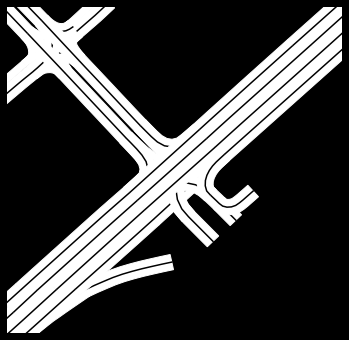

In [4]:
# Generate a rasterized representation of the map 
# (Just to illustrate the driveable area, not required in our algorithm)

import model.datasets.argoverse.map_functions as map_functions

file_id = "2" # Override this variable to compute a different local map
dist_around = 40 # m around the ego-vehicle
dist_rasterized_map = [-dist_around, dist_around, -dist_around, dist_around]  

path = os.path.join(root_file_name,str(file_id)+".csv")
data = dataset_utils.read_file(path) 

origin_pos, city_name = dataset_utils.get_origin_and_city(data,20)
origin_pos = origin_pos[0].tolist() # [x,y]

map_functions.map_generator(file_id,
                            origin_pos,
                            dist_rasterized_map,
                            avm,
                            city_name,
                            show=False,
                            root_folder=data_images_folder)

In [58]:
# Goal points hyperparameters

change_img_bg = False
num_initial_samples = 1000
pred_seconds = 3 # [seconds] To compute the goal points 
                 #           until pred_seconds ahead (assuming constant velocity)
NUM_GOAL_POINTS = 32
NUM_CLUSTERS = 6 # According to the required multimodality

In [5]:
# 0. Load image

filename = data_images_folder + "/" + str(file_id) + ".png"
real_world_offset = dist_around

img = cv2.imread(filename)
img = cv2.resize(img, dsize=(600,600))
height, width = img.shape[:2]
img_size = height
scale_x = scale_y = float(height/(2*real_world_offset))

cx = int(width/2)
cy = int(height/2)
car_px = (cy,cx)

In [6]:
# 1. Get past observations

obs_len = 20
pred_len = 30
seq_len = obs_len + pred_len
skip = 1
threshold = 2 # meters
obs_origin = 20

frames = np.unique(data[:, 0]).tolist() 
frame_data = []
for frame in frames:
    frame_data.append(data[frame == data[:, 0], :]) # save info for each frame

num_sequences = int(math.ceil((len(frames) - seq_len + 1) / skip))
idx = 0

num_objs_considered, _non_linear_obj, curr_loss_mask, curr_seq, \
curr_seq_rel, id_frame_list, object_class_list, city_id, ego_origin = \
    dataset.process_window_sequence(idx, frame_data, frames, \
                            seq_len, pred_len, threshold, file_id, split, obs_origin)

In [54]:
# 2. Plot AGENT observed trajectory

goal_points_folder = split_folder + "/goal_points"

if not os.path.exists(goal_points_folder):
    print("Create goal points folder: ", goal_points_folder)
    os.makedirs(goal_points_folder) # makedirs creates intermediate folders

seq_id = file_id

agent_index = np.where(object_class_list == 1)[0].item()
agent_obs_seq = curr_seq[agent_index,:,:obs_origin].transpose() # 20 x 2 ("abs" around 0)
agent_obs_seq_global = agent_obs_seq + origin_pos # abs (hdmap coordinates)
agent_obs_seq_global = torch.from_numpy(agent_obs_seq_global)

obs_px_points = goal_points_functions.transform_real_world2px(agent_obs_seq_global, origin_pos, real_world_offset, img_size)
agent_obs_px_x, agent_obs_px_y = obs_px_points[:,0], obs_px_points[:,1]
filename = goal_points_folder + "/" + seq_id + "_obs_traj.png"
goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, change_bg=change_img_bg)

In [57]:
# 3. Get feasible area points (N samples)

# 3.0. (Optional) Observe random sampling in the whole feasible area

rad = 1000 # meters. Cause we want to observe all points around the AGENT

fe_y, fe_x = goal_points_functions.get_points(img, car_px, scale_x, rad=10000, color=255, N=num_initial_samples, 
                        sample_car=True, max_samples=None) # return rows, columns
filename = goal_points_folder + "/" + seq_id + "_all_samples.png"
goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, 
                                    goals_px_x=fe_x, goals_px_y=fe_y, change_bg=change_img_bg)

# 3.1. Filter using AGENT estimated velocity in the last observation frame

mean_vel = goal_points_functions.get_agent_velocity(torch.transpose(agent_obs_seq_global,0,1))
radius = mean_vel * pred_seconds
radius_px = radius * scale_x	

fe_y, fe_x = goal_points_functions.get_points(img, car_px, scale_x, rad=radius_px, color=255, N=1024, 
                            sample_car=True, max_samples=None) # return rows, columns

filename = goal_points_folder + "/" + seq_id + "_vel_filter.png"
goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, 
                                    goals_px_x=fe_x, goals_px_y=fe_y, radius=radius_px, change_bg=change_img_bg)

# 3.1. Filter using AGENT estimated orientation (yaw) in the last observation frame

mean_yaw = goal_points_functions.get_agent_yaw(torch.transpose(agent_obs_seq_global,0,1)) # radians

if mean_yaw >= 0.0:
    angle = math.pi/2 - mean_yaw
elif mean_yaw < 0.0:
    angle = -(math.pi / 2 + (math.pi - abs(mean_yaw)))

c, s = np.cos(angle), np.sin(angle)
R = np.array([[c,-s], [s, c]])

fe_x_trans = fe_x - cx # get px w.r.t. the center of the image to be rotated
fe_y_trans = fe_y - cy

close_pts = np.hstack((fe_x_trans.reshape(-1,1),fe_y_trans.reshape(-1,1)))
close_pts_rotated = np.matmul(close_pts,R).astype(np.int32)

fe_x_rot = close_pts_rotated[:,0] + cx
fe_y_rot = close_pts_rotated[:,1] + cy

filtered_fe_x = fe_x[np.where(fe_y_rot < cy)[0]]
filtered_fe_y = fe_y[np.where(fe_y_rot < cy)[0]]

filename = goal_points_folder + "/" + seq_id + "_angle_filter.png"
goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, 
                                    goals_px_x=filtered_fe_x, goals_px_y=filtered_fe_y, radius=radius_px, change_bg=change_img_bg)                                  

In [59]:
# 4. Get furthest N samples (closest the the hypothetical radius)

dist = []
for i in range(len(filtered_fe_x)):
    d = math.sqrt(pow(filtered_fe_x[i] - car_px[0],2) + pow(filtered_fe_y[i] - car_px[1],2))
    dist.append(d)

dist = np.array(dist)

furthest_indeces = np.argsort(dist)
if len(furthest_indeces) > NUM_GOAL_POINTS:
    furthest_indeces = np.argsort(dist)[-NUM_GOAL_POINTS:]

final_samples_x, final_samples_y = filtered_fe_x[furthest_indeces], filtered_fe_y[furthest_indeces]

try:
    diff_points = NUM_GOAL_POINTS - len(final_samples_x)
    final_samples_x = np.hstack((final_samples_x, final_samples_x[0]+0.2 * np.random.randn(diff_points)))
    final_samples_y = np.hstack((final_samples_y, final_samples_y[0]+0.2 * np.random.randn(diff_points)))
except:
    final_samples_x = cx + scale_x*np.random.randn(NUM_GOAL_POINTS)
    final_samples_y = cy + scale_y*np.random.randn(NUM_GOAL_POINTS)

filename = goal_points_folder + "/" + seq_id + "_final_samples.png"
goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, 
                                    goals_px_x=final_samples_x, goals_px_y=final_samples_y, radius=radius_px, change_bg=change_img_bg)

if len(final_samples_x) != NUM_GOAL_POINTS:
    print(f"Final samples does not match with {NUM_GOAL_POINTS} required samples")
    goal_points_functions.plot_fepoints(img, filename, agent_obs_px_x, agent_obs_px_y, car_px, 
                                        goals_px_x=final_samples_x, goals_px_y=final_samples_y, radius=radius_px, change_bg=change_img_bg)

In [ ]:
# 5. Transform pixels to real-world coordinates

final_samples_px = np.hstack((final_samples_y.reshape(-1,1), final_samples_x.reshape(-1,1))) # rows, columns
rw_points = goal_points_functions.transform_px2real_world(final_samples_px, origin_pos, real_world_offset, img_size)

In [ ]:
# 6. TODO: Get heatmap and clusters according to the required multimodality